In [1]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
from tqdm.notebook import tqdm
tqdm().pandas()
from tensorflow.keras.optimizers import *
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from keras_facenet import FaceNet
from mtcnn.mtcnn import MTCNN

0it [00:00, ?it/s]

In [14]:
def convert_images_to_rgb(root_folder):
    """
    Converte todas as imagens em um diretório e seus subdiretórios para o formato RGB.
    
    Args:
        root_folder (str): Caminho para a pasta raiz contendo os subdiretórios com as imagens.
    """
    for subdir, _, files in os.walk(root_folder):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                with Image.open(file_path) as img:
                    if img.mode != 'RGB':
                        img = img.convert('RGB')
                        img.save(file_path)
                        print(f'Convertido para RGB: {file_path}')
                    else:
                        print(f'Já está em RGB: {file_path}')
            except Exception as e:
                print(f'Erro ao processar {file_path}: {e}')

# Caminho para a pasta raiz
root_folder = "./Matrice_png"
convert_images_to_rgb(root_folder)

Já está em RGB: ./Matrice_png\Daninha\ANDIRA_1.png
Já está em RGB: ./Matrice_png\Daninha\ANDIRA_2.png
Já está em RGB: ./Matrice_png\Daninha\ANDIRA_3.png
Já está em RGB: ./Matrice_png\Daninha\ANDIRA_4.png
Já está em RGB: ./Matrice_png\Daninha\ANDIRA_5.png
Já está em RGB: ./Matrice_png\Daninha\ANDIRA_6.png
Já está em RGB: ./Matrice_png\Daninha\ANDIRA_7.png
Já está em RGB: ./Matrice_png\Daninha\ANDIRA_8.png
Já está em RGB: ./Matrice_png\Daninha\ANDIRA_9.png
Já está em RGB: ./Matrice_png\Daninha\ERIOBOTRYA_1.png
Já está em RGB: ./Matrice_png\Daninha\ERYTHRINA_1.png
Já está em RGB: ./Matrice_png\Daninha\HANDROANTHUS_1.png
Já está em RGB: ./Matrice_png\Daninha\ORMOSIA_HENRY_1.png
Já está em RGB: ./Matrice_png\Daninha\ORMOSIA_HENRY_2.png
Já está em RGB: ./Matrice_png\Daninha\ORMOSIA_HENRY_3.png
Já está em RGB: ./Matrice_png\Daninha\psidium_cattle_1.png
Já está em RGB: ./Matrice_png\Daninha\psidium_guajav_1.png
Já está em RGB: ./Matrice_png\Daninha\spathodea_1.png
Já está em RGB: ./Matrice_png

In [15]:
# Diretório das imagens
dataset_path = './Matrice_png'

# Função para carregar imagens e rótulos
def load_dataset(dataset_path, target_size=(299, 299)):
    data = []
    labels = []
    classes = os.listdir(dataset_path)
    
    for class_label in classes:
        class_path = os.path.join(dataset_path, class_label)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = Image.open(img_path).resize(target_size)
                img = np.array(img)
                data.append(img)
                labels.append(class_label)
    
    return np.array(data), np.array(labels)

In [16]:

X, y = load_dataset(dataset_path)

In [17]:
# Inicializar o modelo base
base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
model = Model(inputs=base_model.input, outputs=base_model.output)

In [18]:

# Inicializar o gerador de dados com augmentação
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Pré-processar as imagens
X_preprocessed = preprocess_input(X)

In [19]:

# Gerar embeddings para imagens aumentadas
embeddings = []
labels = []

for i in range(len(X_preprocessed)):
    img = X_preprocessed[i]
    label = y[i]
    
    img = np.expand_dims(img, axis=0)
    
    for batch in datagen.flow(img, batch_size=1):
        augmented_img = batch[0]
        augmented_img = np.expand_dims(augmented_img, axis=0)
        embedding = model.predict(augmented_img)
        
        embeddings.append(embedding[0])
        labels.append(label)
        
        # Gerar 5 aumentos por imagem
        if len(labels) >= (i+1) * 5:
            break

# Converter para DataFrame
embeddings_df = pd.DataFrame({
    'Classe': labels,
    'embedding': list(embeddings)
})

1/1 [==============================] - 0s 75ms/step


In [20]:
# Salvar o DataFrame em um CSV
embeddings_df.to_csv('embeddings_with_augmentation_matrice.csv', index=False)

In [21]:
np.savez_compressed('embeddings_with_augmentation_matrice.npz', embeddings=embeddings, labels=y)

In [22]:
print(embeddings_df.head())

    Classe                                          embedding
0  Daninha  [0.15025716, 0.1363607, 0.11102749, 0.19376248...
1  Daninha  [0.034448422, 0.10048885, 0.17525256, 0.136251...
2  Daninha  [0.028678495, 0.14451991, 0.01997426, 0.405101...
3  Daninha  [0.21235135, 0.22944842, 0.12351295, 0.2267802...
4  Daninha  [0.08023298, 0.1601995, 0.05822358, 0.5506959,...


In [17]:
# Carregar embeddings e rótulos
X = np.array(embeddings_df['embedding'].tolist())
y = np.array(embeddings_df['Classe'].tolist())


label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [18]:

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(np.unique(y_encoded)), activation='softmax')
])

In [19]:

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/25
15/15 [==============================] - 1s 15ms/step - loss: 2.5483 - accuracy: 0.5349 - val_loss: 23.7839 - val_accuracy: 0.2353
Epoch 2/25
15/15 [==============================] - 0s 7ms/step - loss: 2.7384 - accuracy: 0.6765 - val_loss: 3.9758 - val_accuracy: 0.8067
Epoch 3/25
15/15 [==============================] - 0s 7ms/step - loss: 2.5744 - accuracy: 0.7442 - val_loss: 2.7881 - val_accuracy: 0.7731
Epoch 4/25
15/15 [==============================] - 0s 7ms/step - loss: 2.2637 - accuracy: 0.7928 - val_loss: 2.1218 - val_accuracy: 0.8908
Epoch 5/25
15/15 [==============================] - 0s 6ms/step - loss: 1.8591 - accuracy: 0.8774 - val_loss: 1.7394 - val_accuracy: 0.9244
Epoch 6/25
15/15 [==============================] - 0s 7ms/step - loss: 1.6884 - accuracy: 0.8732 - val_loss: 1.6065 - val_accuracy: 0.8739
Epoch 7/25
15/15 [==============================] - 0s 7ms/step - loss: 1.4580 - accuracy: 0.8816 - val_loss: 1.5356 - val_accuracy: 0.8739
Epoch 8/25
15/15 [

In [21]:

y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
test_accuracy = accuracy_score(y_test, y_test_pred_classes)
print(f'Test Accuracy: {test_accuracy:.2f}')

5/5 [==============================] - 0s 2ms/step
Test Accuracy: 0.84


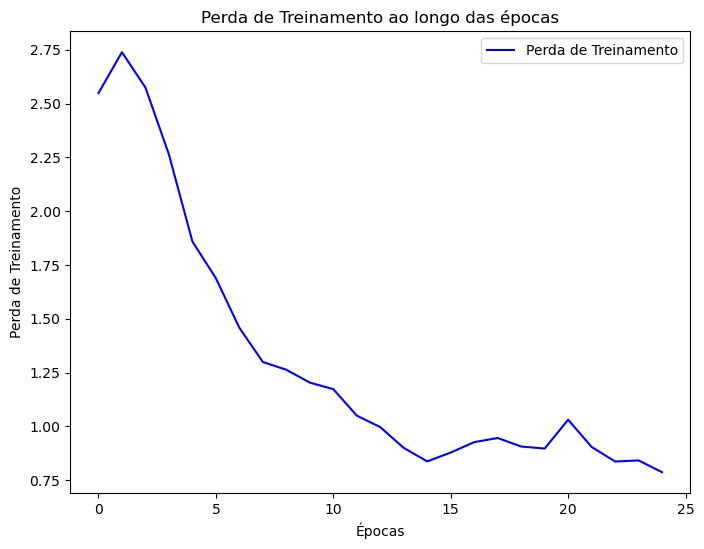

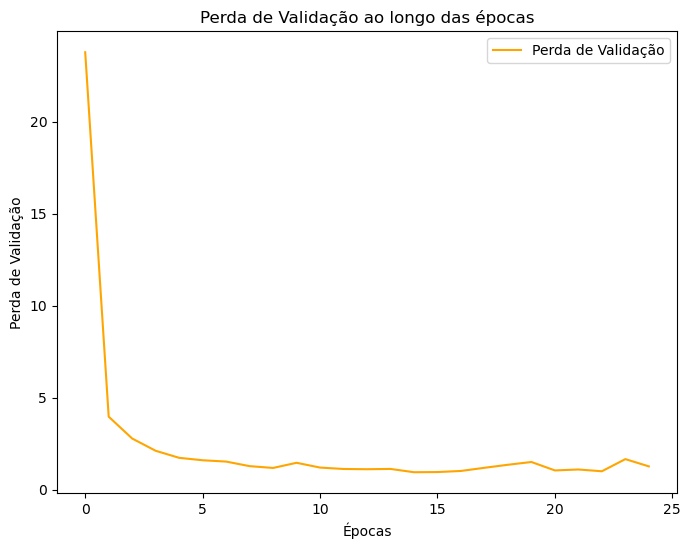

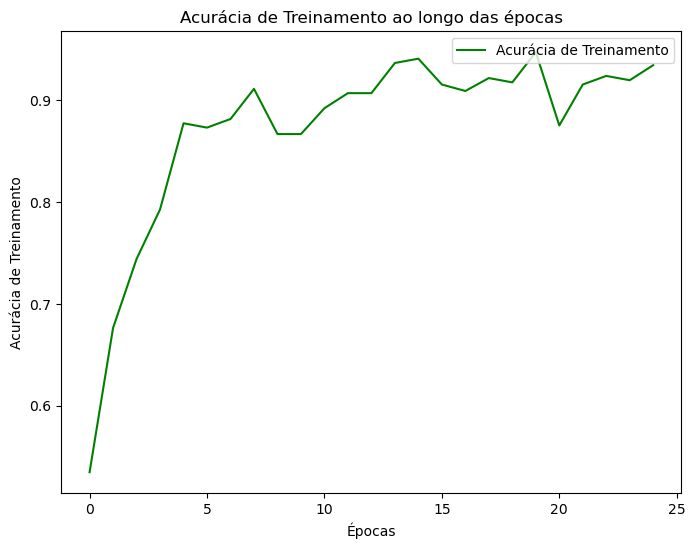

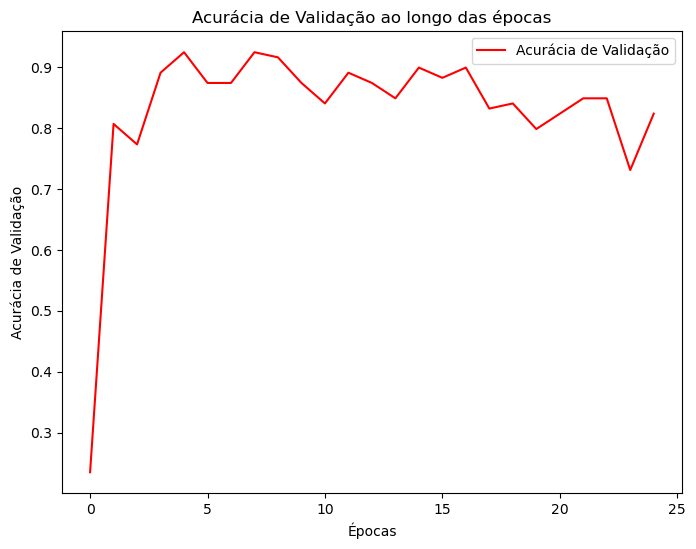

In [22]:
import matplotlib.pyplot as plt

# Função para plotar as métricas separadamente
def plot_history(history):
    # Gráfico da perda de treinamento
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Perda de Treinamento', color='blue')
    plt.title('Perda de Treinamento ao longo das épocas')
    plt.xlabel('Épocas')
    plt.ylabel('Perda de Treinamento')
    plt.legend(loc='upper right')
    plt.show()

    # Gráfico da perda de validação
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['val_loss'], label='Perda de Validação', color='orange')
    plt.title('Perda de Validação ao longo das épocas')
    plt.xlabel('Épocas')
    plt.ylabel('Perda de Validação')
    plt.legend(loc='upper right')
    plt.show()

    # Gráfico da acurácia de treinamento
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Acurácia de Treinamento', color='green')
    plt.title('Acurácia de Treinamento ao longo das épocas')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia de Treinamento')
    plt.legend(loc='upper right')
    plt.show()

    # Gráfico da acurácia de validação
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['val_accuracy'], label='Acurácia de Validação', color='red')
    plt.title('Acurácia de Validação ao longo das épocas')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia de Validação')
    plt.legend(loc='upper right')
    plt.show()

# Plotar os gráficos
plot_history(history)


In [23]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from datetime import datetime

embeddings_df = './embeddings_with_augmentation.csv'

def create_output_directory():
    """
    Cria diretório para salvar os resultados
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f'resultados_treinamento_{timestamp}'
    os.makedirs(output_dir, exist_ok=True)
    return output_dir

def load_and_prepare_data(embeddings_df):
    """
    Carrega e prepara os dados para treinamento
    """
    print("Preparando dados...")
    X = np.array(embeddings_df['embedding'].tolist())
    y = np.array(embeddings_df['Classe'].tolist())
    
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42
    )
    
    return X_train, X_test, y_train, y_test, label_encoder

def create_model(input_shape, num_classes):
    """
    Cria o modelo de classificação
    """
    model = Sequential([
        Dense(256, activation='relu', input_shape=input_shape, 
              kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, 
                 loss='sparse_categorical_crossentropy', 
                 metrics=['accuracy'])
    
    return model

def plot_training_metrics(history, output_dir):
    """
    Plota e salva os gráficos de métricas de treinamento
    """
    metrics = {
        'loss': ('Perda de Treinamento', 'blue'),
        'val_loss': ('Perda de Validação', 'orange'),
        'accuracy': ('Acurácia de Treinamento', 'green'),
        'val_accuracy': ('Acurácia de Validação', 'red')
    }
    
    for metric, (title_base, color) in metrics.items():
        plt.figure(figsize=(8, 6))
        plt.plot(history.history[metric], label=title_base, color=color)
        plt.title(f'{title_base} ao longo das épocas')
        plt.xlabel('Épocas')
        plt.ylabel(title_base)
        plt.legend(loc='upper right')
        plt.savefig(os.path.join(output_dir, f'{metric}_plot.png'))
        plt.close()

def plot_confusion_matrix(y_true, y_pred, classes, output_dir):
    """
    Plota e salva a matriz de confusão
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Matriz de Confusão')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
    plt.close()

def save_training_results(history, train_time, test_results, output_dir):
    """
    Salva os resultados do treinamento em arquivo de texto
    """
    with open(os.path.join(output_dir, 'training_results.txt'), 'w') as f:
        # Informações de tempo
        f.write("=== Informações de Tempo ===\n")
        f.write(f"Tempo total de treinamento: {train_time:.2f} segundos ({train_time/60:.2f} minutos)\n\n")
        
        # Métricas finais
        f.write("=== Métricas Finais ===\n")
        f.write(f"Acurácia de teste: {test_results['accuracy']:.4f}\n")
        f.write("\n=== Classification Report ===\n")
        f.write(test_results['classification_report'])
        
        # Histórico de treinamento
        f.write("\n=== Histórico de Treinamento ===\n")
        for epoch, (loss, val_loss, acc, val_acc) in enumerate(zip(
            history.history['loss'],
            history.history['val_loss'],
            history.history['accuracy'],
            history.history['val_accuracy']
        ), 1):
            f.write(f"\nÉpoca {epoch}:\n")
            f.write(f"  Perda de treinamento: {loss:.4f}\n")
            f.write(f"  Perda de validação: {val_loss:.4f}\n")
            f.write(f"  Acurácia de treinamento: {acc:.4f}\n")
            f.write(f"  Acurácia de validação: {val_acc:.4f}\n")

def main(embeddings_df):
    # Criar diretório para resultados
    output_dir = create_output_directory()
    print(f"Resultados serão salvos em: {output_dir}")
    
    # Carregar e preparar dados
    X_train, X_test, y_train, y_test, label_encoder = load_and_prepare_data(embeddings_df)
    
    # Criar e treinar modelo
    print("\nCriando e treinando modelo...")
    model = create_model((X_train.shape[1],), len(np.unique(y_train)))
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=25,
        restore_best_weights=True
    )
    
    # Iniciar cronômetro
    start_time = time.time()
    
    # Treinar modelo
    history = model.fit(
        X_train, y_train,
        epochs=25,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Calcular tempo total de treinamento
    train_time = time.time() - start_time
    
    # Avaliação do modelo
    print("\nAvaliando modelo...")
    y_test_pred = model.predict(X_test)
    y_test_pred_classes = np.argmax(y_test_pred, axis=1)
    
    test_results = {
        'accuracy': accuracy_score(y_test, y_test_pred_classes),
        'classification_report': classification_report(
            y_test, 
            y_test_pred_classes,
            target_names=label_encoder.classes_,
            digits=4
        )
    }
    
    # Gerar e salvar visualizações
    print("\nGerando visualizações...")
    plot_training_metrics(history, output_dir)
    plot_confusion_matrix(
        y_test,
        y_test_pred_classes,
        label_encoder.classes_,
        output_dir
    )
    
    # Salvar resultados
    save_training_results(history, train_time, test_results, output_dir)
    
    # Imprimir resultados principais
    print("\n=== Resultados do Treinamento ===")
    print(f"Tempo total de treinamento: {train_time:.2f} segundos ({train_time/60:.2f} minutos)")
    print(f"Acurácia de teste: {test_results['accuracy']:.4f}")
    print("\nClassification Report:")
    print(test_results['classification_report'])
    print(f"\nTodos os resultados foram salvos em: {output_dir}")
    
    return model, history, test_results

if __name__ == "__main__":
    # Assumindo que embeddings_df já está carregado
    model, history, test_results = main(embeddings_df)

Resultados serão salvos em: resultados_treinamento_20241111_145207
Preparando dados...


TypeError: string indices must be integers, not 'str'

In [25]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import os
import zipfile
from datetime import datetime
import time

def load_and_prepare_data(csv_file):
    """
    Carrega e prepara os dados do CSV com embeddings
    """
    df = pd.read_csv(csv_file)

    # Converte as strings de embeddings para arrays numpy
    embeddings = df['embedding'].apply(lambda x: np.fromstring(
        x.strip('[]'), sep=' ')).values
    embeddings = np.stack(embeddings)

    # Codifica as classes
    le = LabelEncoder()
    labels = le.fit_transform(df['Classe'])

    return embeddings, labels, le.classes_

def create_model(input_dim, num_classes):
    """
    Cria o modelo de classificação
    """
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.01) #mudar o otimizador por aqui
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def plot_fold_history(histories, output_dir):
    """
    Plota o histórico de treinamento para todos os folds
    """
    plt.figure(figsize=(15, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    for fold, history in enumerate(histories):
        plt.plot(history.history['accuracy'], label=f'Treino Fold {fold+1}')
        plt.plot(history.history['val_accuracy'], label=f'Val Fold {fold+1}', linestyle='--')
    plt.title('Acurácia do Modelo por Fold')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    for fold, history in enumerate(histories):
        plt.plot(history.history['loss'], label=f'Treino Fold {fold+1}')
        plt.plot(history.history['val_loss'], label=f'Val Fold {fold+1}', linestyle='--')
    plt.title('Perda do Modelo por Fold')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'training_history.png'))
    plt.close()

def plot_fold_metrics(fold_scores, output_dir):
    """
    Plota as métricas finais de cada fold em um gráfico de barras
    """
    plt.figure(figsize=(10, 6))
    folds = range(1, len(fold_scores) + 1)
    plt.bar(folds, fold_scores)
    plt.axhline(y=np.mean(fold_scores), color='r', linestyle='--', label='Média')
    
    plt.title('Acurácia por Fold')
    plt.xlabel('Número do Fold')
    plt.ylabel('Acurácia')
    plt.ylim([0, 1])
    
    for i, v in enumerate(fold_scores):
        plt.text(i + 1, v + 0.01, f'{v:.4f}', ha='center')
    
    plt.legend()
    plt.savefig(os.path.join(output_dir, 'fold_metrics.png'))
    plt.close()

def plot_confusion_matrix(y_true, y_pred, classes, output_dir):
    """
    Plota e salva a matriz de confusão
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title('Matriz de Confusão')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
    plt.close()

def save_results(fold_scores, classification_rep, fold_times, total_time, output_dir):
    """
    Salva os resultados em arquivos de texto
    """
    # Salva as acurácias por fold e tempos de treinamento
    with open(os.path.join(output_dir, 'fold_accuracies.txt'), 'w') as f:
        f.write("Resultados por Fold:\n")
        for i, (score, time_taken) in enumerate(zip(fold_scores, fold_times)):
            f.write(f"Fold {i+1}:\n")
            f.write(f"  Acurácia: {score:.4f}\n")
            f.write(f"  Tempo de treinamento: {time_taken:.2f} segundos ({time_taken/60:.2f} minutos)\n")
        
        f.write(f"\nMédia de Acurácia: {np.mean(fold_scores):.4f}")
        f.write(f"\nDesvio Padrão de Acurácia: {np.std(fold_scores):.4f}")
        f.write(f"\n\nTempo médio por fold: {np.mean(fold_times):.2f} segundos ({np.mean(fold_times)/60:.2f} minutos)")
        f.write(f"\nTempo total de treinamento: {total_time:.2f} segundos ({total_time/60:.2f} minutos)")

    # Salva o classification report
    with open(os.path.join(output_dir, 'classification_report.txt'), 'w') as f:
        f.write(classification_rep)

def create_zip_archive(output_dir, zip_filename):
    """
    Cria um arquivo zip com todos os resultados
    """
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for root, dirs, files in os.walk(output_dir):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, output_dir)
                zipf.write(file_path, arcname)

def main():
    # Parâmetros
    csv_file = './balanced_embeddings_matrice.csv'
    k_folds = 10
    epochs = 100
    batch_size = 32

    # Cria diretório para os resultados
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_dir = f'resultados_kfold_{timestamp}'
    os.makedirs(output_dir, exist_ok=True)

    print("Carregando dados...")
    embeddings, labels, classes = load_and_prepare_data(csv_file)

    # Inicializa o K-Fold
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Armazena métricas e históricos
    fold_histories = []
    fold_scores = []
    fold_times = []  # Lista para armazenar o tempo de cada fold
    all_predictions = []
    all_true_labels = []

    # Marca o início do treinamento total
    total_start_time = time.time()

    # Loop através dos folds
    for fold, (train_idx, val_idx) in enumerate(kf.split(embeddings)):
        print(f"\nFold {fold + 1}/{k_folds}")
        print("-" * 20)

        X_train, X_val = embeddings[train_idx], embeddings[val_idx]
        y_train, y_val = labels[train_idx], labels[val_idx]

        print(f"Treino: {X_train.shape}, Validação: {X_val.shape}")

        model = create_model(embeddings.shape[1], len(classes))
        
        # Marca o início do treinamento do fold
        fold_start_time = time.time()
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )
        
        # Calcula o tempo do fold
        fold_time = time.time() - fold_start_time
        fold_times.append(fold_time)

        # Avaliação e predições
        scores = model.evaluate(X_val, y_val, verbose=0)
        predictions = model.predict(X_val)
        predicted_classes = np.argmax(predictions, axis=1)
        
        print(f"\nFold {fold + 1} - Perda: {scores[0]:.4f}, Acurácia: {scores[1]:.4f}")
        print(f"Tempo de treinamento do fold: {fold_time:.2f} segundos ({fold_time/60:.2f} minutos)")

        # Armazena resultados
        fold_histories.append(history)
        fold_scores.append(scores[1])
        all_predictions.extend(predicted_classes)
        all_true_labels.extend(y_val)

    # Calcula o tempo total de treinamento
    total_time = time.time() - total_start_time

    # Gera e salva resultados finais
    print("\nGerando relatórios e visualizações...")
    
    # Classification Report
    report = classification_report(all_true_labels, all_predictions, 
                                 target_names=classes, digits=4)
    print("\nClassification Report:")
    print(report)

    # Gera todas as visualizações e salva resultados
    plot_fold_history(fold_histories, output_dir)
    plot_fold_metrics(fold_scores, output_dir)
    plot_confusion_matrix(all_true_labels, all_predictions, classes, output_dir)
    save_results(fold_scores, report, fold_times, total_time, output_dir)

    # Cria arquivo zip com os resultados
    zip_filename = f'{output_dir}.zip'
    create_zip_archive(output_dir, zip_filename)

    print(f"\nProcesso completo. Resultados e arquivos salvos em: {zip_filename}")

if __name__ == "__main__":
    main()


Carregando dados...

Fold 1/10
--------------------
Treino: (675, 3), Validação: (75, 3)
Epoch 1/100
22/22 [==============================] - 1s 7ms/step - loss: 1.8478 - accuracy: 0.3363 - val_loss: 1.4189 - val_accuracy: 0.3067
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 1.4687 - accuracy: 0.4385 - val_loss: 1.4136 - val_accuracy: 0.4267
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 1.4627 - accuracy: 0.3896 - val_loss: 1.4137 - val_accuracy: 0.3600
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 1.3917 - accuracy: 0.4296 - val_loss: 1.3881 - val_accuracy: 0.3733
Epoch 5/100
22/22 [==============================] - 0s 2ms/step - loss: 1.4204 - accuracy: 0.3941 - val_loss: 1.3788 - val_accuracy: 0.3733
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 1.3609 - accuracy: 0.4089 - val_loss: 1.3561 - val_accuracy: 0.4000
Epoch 7/100
22/22 [==============================] - 0s 2ms/step 

In [23]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

# Carregar os dados
file_path = './embeddings_with_augmentation_matrice.csv'
data = pd.read_csv(file_path)

# Corrigir formatação e converter embeddings para vetores NumPy
def fix_and_convert_embedding(embedding_str):
    # Remove leading/trailing whitespace and brackets
    embedding_str = embedding_str.strip('[]')
    
    # Convert the string to a NumPy array
    values = np.fromstring(embedding_str, sep=' ')
    
    return values

def preprocess_embeddings(data):
    data['embedding'] = data['embedding'].apply(fix_and_convert_embedding)
    return data

# Aplicar SMOTE para balancear classes
def apply_smote(data, target_column, embedding_column):
    # Separar as features (X) e o alvo (y)
    X = np.stack(data[embedding_column].values)
    y = data[target_column]
    
    # Aplicar SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    # Retornar os dados balanceados como um novo DataFrame
    balanced_data = pd.DataFrame({
        target_column: y_resampled,
        embedding_column: list(X_resampled)
    })
    return balanced_data

# Processar os dados e aplicar SMOTE
data = preprocess_embeddings(data)
balanced_data = apply_smote(data, target_column="Classe", embedding_column="embedding")

# Salvar o resultado em um novo arquivo CSV
output_path = 'balanced_embeddings_matrice.csv'
balanced_data.to_csv(output_path, index=False)

print(f"Arquivo balanceado salvo em: {output_path}")

Arquivo balanceado salvo em: balanced_embeddings_matrice.csv
